In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow_hub as hub    
import tensorflow as tf
import Augmentor
from IPython.display import Image as Im
from IPython.display import display
%matplotlib inline

# 1. Introduction to the data and models
> In the Doc.

### 1.1 Plotting some images

adenocarcinoma Image


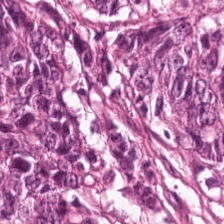

benign Image


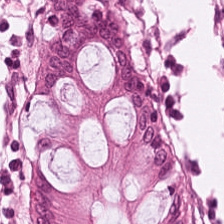

noneType Image


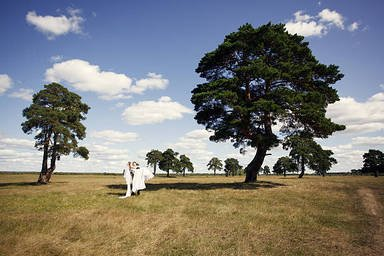

In [2]:
from IPython.display import Image as Im
from IPython.display import display


data_dir = 'D:/image_processing/Colon/test/original_test'
adeno_img = os.path.join(data_dir, 'adenocarcinoma/TUM-TCGA-AAHIDTWA.jpg')
benign_img = os.path.join(data_dir, 'benign/NORM-TCGA-ADVTWHRS.jpg')
noneType_img = os.path.join(data_dir, 'noneType/84.jpg')


adeno = Im(adeno_img) 
benign = Im(benign_img)
noneType = Im(noneType_img)
print('adenocarcinoma Image')
display(adeno)
print('benign Image')
display(benign)
print('noneType Image')
display(noneType)

### 1.2 Images Info

In [3]:
adeno_1 = Image.open(adeno_img)
benign_1 = Image.open(benign_img)
noneType_1 = Image.open(noneType_img)

In [4]:
 
adeno_info_dict = {
    "Filename": adeno_1.filename,
    "Image Size": adeno_1.size,
    "Image Height": adeno_1.height,
    "Image Width": adeno_1.width,
    "Image Format": adeno_1.format,
    "Image Mode": adeno_1.mode,
}
benign_info_dict = {
    "Filename": benign_1.filename,
    "Image Size": benign_1.size,
    "Image Height": benign_1.height,
    "Image Width": benign_1.width,
    "Image Format": benign_1.format,
    "Image Mode": benign_1.mode,
}
noneType_info_dict = {
    "Filename": noneType_1.filename,
    "Image Size": noneType_1.size,
    "Image Height": noneType_1.height,
    "Image Width": noneType_1.width,
    "Image Format": noneType_1.format,
    "Image Mode": noneType_1.mode,
}
print('Adenomatous Images Info')
for label,value in adeno_info_dict.items():
    print(f"{label:25}: {value}")

print('')
print('Benign Images Info')
for label,value in benign_info_dict.items():
    print(f"{label:25}: {value}")

print('')
print('NoneType Images Info')
for label,value in noneType_info_dict.items():
    print(f"{label:25}: {value}")


Adenomatous Images Info
Filename                 : D:/image_processing/Colon/test/original_test\adenocarcinoma/TUM-TCGA-AAHIDTWA.jpg
Image Size               : (224, 224)
Image Height             : 224
Image Width              : 224
Image Format             : JPEG
Image Mode               : RGB

Benign Images Info
Filename                 : D:/image_processing/Colon/test/original_test\benign/NORM-TCGA-ADVTWHRS.jpg
Image Size               : (224, 224)
Image Height             : 224
Image Width              : 224
Image Format             : JPEG
Image Mode               : RGB

NoneType Images Info
Filename                 : D:/image_processing/Colon/test/original_test\noneType/84.jpg
Image Size               : (384, 256)
Image Height             : 256
Image Width              : 384
Image Format             : JPEG
Image Mode               : RGB


### 1.3 Loading the model and testing 

In [5]:
# loading the trained Inception_V3 model

custom_objects = {'KerasLayer': hub.KerasLayer}
model = tf.keras.models.load_model('D:/Grad_Proj/colon_histo/main/saved_model/histo_class_final.h5', custom_objects=custom_objects)

In [6]:
batch_size = 16
IMG_SHAPE = 299
base_dir = 'D:/image_processing/Colon'
test_dir = os.path.join(base_dir, 'test/original_test')

device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'

In [7]:
test_data = tf.keras.utils.image_dataset_from_directory(directory = test_dir,
                                                           labels = 'inferred',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')

Found 4612 files belonging to 3 classes.


In [8]:
@tf.function
def map_fn(img, label):
    image_height = IMG_SHAPE
    image_width = IMG_SHAPE
    img = tf.image.resize(img, [image_height, image_width])
    img /= 255
    return img, label
test = test_data.map(map_fn)

In [9]:
loss, accuracy_d = model.evaluate(test, verbose=2)
print("Model Loss: {:5.2f} , Model Accuracy: {:5.2f}%".format(loss, 100 * accuracy_d))

289/289 - 37s - loss: 0.0375 - accuracy: 0.9876 - 37s/epoch - 127ms/step
Model Loss:  0.04 , Model Accuracy: 98.76%


# 2. Augmenting the images 

#### We have 4612 images in the directory which are split into 1233, 741, and 2638 for adenocarcinoma, benign, and noneType classes
#### Since we have two undersampled calsses, We will be augmenting them

### 2.1 Augmenting adenocarcinoma folder

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io

datagen = ImageDataGenerator(        
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        vertical_flip=True,
        brightness_range = (0.5, 1.5))

image_directory = r'D:/image_processing/Colon/test/adenocarcinoma/'
SIZE = 299
dataset = []
my_images = os.listdir(image_directory)

for i, image_name in enumerate(my_images):    
    if (image_name.split('.')[1] == 'jpg'):        
        image = io.imread(image_directory + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((SIZE,SIZE)) 
        dataset.append(np.array(image))

x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=16, save_to_dir= r'D:/image_processing/Colon/aug_adeno', save_prefix='aug'
                          , save_format='jpg'):
    i += 1    
    if i > 100:        
        break

#### the data is augmented to 1601 new images 

### 2.2 Augmenting benign folder

In [26]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io

datagen = ImageDataGenerator(        
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        vertical_flip=True,
        brightness_range = (0.5, 1.5))

image_directory = r'D:/image_processing/Colon/test/benign/'
SIZE = 299
dataset = []
my_images = os.listdir(image_directory)

for i, image_name in enumerate(my_images):    
    if (image_name.split('.')[1] == 'jpg'):        
        image = io.imread(image_directory + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((SIZE,SIZE)) 
        dataset.append(np.array(image))

x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=16, save_to_dir= r'D:/image_processing/Colon/aug_benign', save_prefix='aug'
                          , save_format='jpg'):
    i += 1    
    if i > 150:        
        break

#### the data is augmented to 2257 new images 

#### After adding the augmented images to their calsses we ended up with:
> 2834 images for the adenocarcinoma class.

> 2998 images for the benign class.

> and, 2638 images for the noneType class.

#### Now we need to make the same transformations on the third class without augmenting

### 2.3 Processing noneType Class

In [34]:
import Augmentor

p = Augmentor.Pipeline("D:/image_processing/Colon/test/noneType")

Initialised with 2638 image(s) found.
Output directory set to D:/image_processing/Colon/test/noneType\output.

In [39]:
try:
    
    p.rotate(probability=0.5, max_left_rotation=15, max_right_rotation=15)
    p.zoom(probability=0.5, min_factor=1, max_factor=1.2)
    p.flip_left_right(probability=0.5)
    p.flip_top_bottom(probability=0.5)
    p.shear(probability=0.5, max_shear_left=20, max_shear_right=20)
    p.random_brightness(probability=0.5, min_factor=0.5, max_factor=1.5)
    p.process()
except KeyError:
    print("key")
except OSError:
    print('os')
except AttributeError:
    print('att')


Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x21D761F5D60>:  18%|█▊        | 481/2638 [00:03<00:16, 128.78 Samples/s]                  


att


### 2.3.1 Image Mode Error handling

In [49]:
dir1 = 'D:/image_processing/Colon/test/noneType'
rgb = []
other = []
otherpath = []
for i in os.listdir(dir1):
    img_path = '{}/{}'.format(dir1, i)
    img = Image.open(img_path)
    if img.mode == 'RGB':
        rgb.append(1)
    else:
        other.append(img.mode)
        otherpath.append(img.filename)

In [50]:
print(other)
print(otherpath)

['RGBA', 'L', 'RGBA', 'RGBA']
['D:/image_processing/Colon/test/noneType/banana_25.jpg', 'D:/image_processing/Colon/test/noneType/corals__ (6073).jpg', 'D:/image_processing/Colon/test/noneType/mixed_16.jpg', 'D:/image_processing/Colon/test/noneType/orange_11.jpg']


In [55]:
len(rgb)

2634

In [51]:
for i in otherpath:
    os.remove(i)

### 2.4 Starting the process

In [58]:
p2 = Augmentor.Pipeline("D:/image_processing/Colon/test/noneType")

Initialised with 2634 image(s) found.
Output directory set to D:/image_processing/Colon/test/noneType\output.

In [59]:
p2.rotate(probability=0.5, max_left_rotation=15, max_right_rotation=15)
p2.zoom(probability=0.5, min_factor=1, max_factor=1.2)
p2.flip_left_right(probability=0.5)
p2.flip_top_bottom(probability=0.5)
p2.shear(probability=0.5, max_shear_left=20, max_shear_right=20)
p2.random_brightness(probability=0.5, min_factor=0.5, max_factor=1.5)
p2.process()

Processing <PIL.Image.Image image mode=RGB size=300x168 at 0x21D74EFC2E0>:  98%|█████████▊| 2584/2634 [00:09<00:00, 280.01 Samples/s]                   


ValueError: Coordinate 'lower' is less than 'upper'

#### Error in processing the images
> Processed 2633 instead of 2634

### 2.4.1 Error handling (Unknown Image Error)

In [74]:
dir1 = 'D:/image_processing/Colon/test/noneType'
rgb = []
other = []
otherpath = []
for i in os.listdir(dir1):
    img_path = '{}/{}'.format(dir1, i)
    img = Image.open(img_path)
    if str(np.array(img).shape)[-2] == '3':
        rgb.append(1)
    else:
        other.append(img.mode)
        otherpath.append(img.filename)

In [77]:
other

[]

In [ ]:
'_bfd70e2d-a89b-41d9-b67f-38247179f70c' '_08f34c80-4569-458c-acb2-c0f21aeeb6db'

In [15]:
none_dir_origin = 'D:/image_processing/Colon/test/original_test/noneType'
none_dir_2 = 'D:/image_processing/Colon/test/augmented_test/noneType'

error_img_path = []
folder_2_1 = []
folder_origin_1 = []

folder_origin = os.listdir(none_dir_origin)
folder_2 = os.listdir(none_dir_2)

for i in folder_2:
    folder_2_1.append(i.split('noneType_original_')[1].split('.jpg')[0])

for i in folder_origin:
    folder_origin_1.append(i.split('.jpg')[0])

for i in folder_origin_1:
    if i not in folder_2_1:
        error_img_path.append(i)
error_img_path

['rollsroy3 (299)']

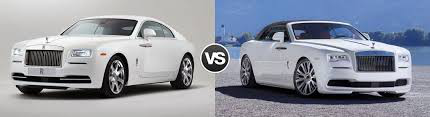

In [17]:
error_img = os.path.join(none_dir_origin, 'rollsroy3 (299).jpg')
err_im = Image.open(error_img)
err_im

In [18]:
os.remove(error_img)

#### Now there will be no more errors in this image set and we processed 2633 images 

#### After augmenting we have 8465 images instead of 4612

### 2.5 Testing the new augmented data 

In [10]:
batch_size = 16
IMG_SHAPE = 299
base_dir2 = 'D:/image_processing/Colon/test'
test_dir2 = os.path.join(base_dir2, 'augmented_test/test_aug')


In [11]:
test_data2 = tf.keras.utils.image_dataset_from_directory(directory = test_dir2,
                                                           labels = 'inferred',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')
test_aug = test_data2.map(map_fn)

Found 8465 files belonging to 3 classes.


In [12]:
loss, accuracy_d = model.evaluate(test_aug, verbose=2)
print("Model Loss: {:5.2f} , Model Accuracy: {:5.2f}%".format(loss, 100 * accuracy_d))

530/530 - 57s - loss: 0.3936 - accuracy: 0.8718 - 57s/epoch - 107ms/step
Model Loss:  0.39 , Model Accuracy: 87.18%


#### The accuracy dropped after augmenting and processing the images from 98.76% to 87.18%

# 3. Image Enhancement and Re-Processing

In [84]:
p3 = Augmentor.Pipeline("D:/image_processing/Colon/test/augmented_test")

Initialised with 8465 image(s) found.
Output directory set to D:/image_processing/Colon/test/augmented_test\output.

In [87]:
p3.random_color(probability=0.5, min_factor=0.9, max_factor=1.6)
p3.random_contrast(probability=0.5, min_factor=0.9, max_factor=1.6)
p3.gaussian_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3, corner="bell", method="in", mex=0.5, mey=0.5, sdx=0.05, sdy=0.05)
p3.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=4)
p3.process()

Processing <PIL.Image.Image image mode=RGB size=259x194 at 0x21C750262E0>: 100%|██████████| 8465/8465 [01:36<00:00, 87.81 Samples/s]                   


### 3.1Testing the enhanced data

In [13]:
base_dir3 = 'D:/image_processing/Colon/test'
test_dir3 = os.path.join(base_dir3, 'augmented_test/test_aug_enh')

In [14]:
test_data3 = tf.keras.utils.image_dataset_from_directory(directory = test_dir3,
                                                           labels = 'inferred',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')
test_aug_enh = test_data3.map(map_fn)

Found 8465 files belonging to 3 classes.


In [15]:
loss, accuracy_d = model.evaluate(test_aug_enh, verbose=2)
print("Model Loss: {:5.2f} , Model Accuracy: {:5.2f}%".format(loss, 100 * accuracy_d))

530/530 - 59s - loss: 0.5119 - accuracy: 0.8400 - 59s/epoch - 111ms/step
Model Loss:  0.51 , Model Accuracy: 84.00%


#### The accuracy dropped after reprocessing and enhancing the images from 87.18% to 84.00%

# 4. Applying filter

In [93]:
# applying the filter on the distorted and processed data
p4 = Augmentor.Pipeline("D:/image_processing/Colon/test/augmented_test/test_aug_enh")

Initialised with 8465 image(s) found.
Output directory set to D:/image_processing/Colon/test/augmented_test/test_aug_enh\output.

In [94]:
p4.histogram_equalisation(probability=1)
p4.process()

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x21D7B5AC610>:  57%|█████▋    | 4855/8465 [00:16<00:03, 951.33 Samples/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Processing <PIL.Image.Image image mode=RGB size=259x194 at 0x21D7BCA37F0>: 100%|██████████| 8465/8465 [00:20<00:00, 414.81 Samples/s]   


### 4.1 Testing the filtered data

In [16]:
base_dir4 = 'D:/image_processing/Colon/test'
test_dir4 = os.path.join(base_dir4, 'augmented_test/test_filter')

In [17]:
test_data4 = tf.keras.utils.image_dataset_from_directory(directory = test_dir4,
                                                           labels = 'inferred',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')
test_filter = test_data4.map(map_fn)

Found 8465 files belonging to 3 classes.


In [18]:
loss, accuracy_d = model.evaluate(test_filter, verbose=2)
print("Model Loss: {:5.2f} , Model Accuracy: {:5.2f}%".format(loss, 100 * accuracy_d))

530/530 - 59s - loss: 1.3709 - accuracy: 0.7119 - 59s/epoch - 112ms/step
Model Loss:  1.37 , Model Accuracy: 71.19%


#### The accuracy dropped after filtering the images from 84.00% to 71.19%

### 4.2 Applying the filter to the augmented images and testing them

In [26]:
p5 = Augmentor.Pipeline("D:/image_processing/Colon/test/augmented_test/test_aug")
p5.histogram_equalisation(probability=1)
p5.process()

Initialised with 8465 image(s) found.
Output directory set to D:/image_processing/Colon/test/augmented_test/test_aug\output.

Processing <PIL.Image.Image image mode=RGB size=259x194 at 0x29E74236430>: 100%|██████████| 8465/8465 [00:22<00:00, 375.10 Samples/s]   


In [19]:
base_dir5 = 'D:/image_processing/Colon/test'
test_dir5 = os.path.join(base_dir5, 'augmented_test/test_aug_filter')

In [20]:
test_data5 = tf.keras.utils.image_dataset_from_directory(directory = test_dir5,
                                                           labels = 'inferred',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')
test_aug_filter = test_data5.map(map_fn)

Found 8465 files belonging to 3 classes.


In [21]:
loss, accuracy_d = model.evaluate(test_aug_filter, verbose=2)
print("Model Loss: {:5.2f} , Model Accuracy: {:5.2f}%".format(loss, 100 * accuracy_d))

530/530 - 61s - loss: 1.3442 - accuracy: 0.7165 - 61s/epoch - 115ms/step
Model Loss:  1.34 , Model Accuracy: 71.65%


#### The Accuracy dropped from 87.18% to 71.65% after applying the filter to the augmented images

# 5. Plotting the results

Original Image with Accuracy 98.76%


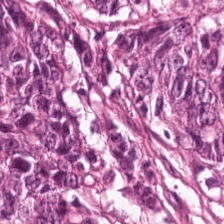

Augmented Image with Accuracy 87.18%


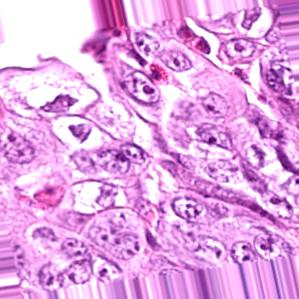

Augmented Enhanced Image with Accuracy 84.00%


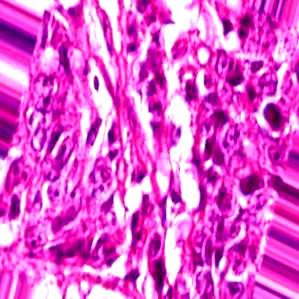

Augmented Enhanced Filtered Image with Accuracy 71.19%


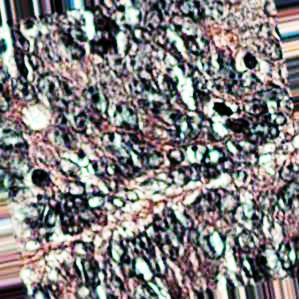

Augmented Filtered Image with Accuracy 71.65%


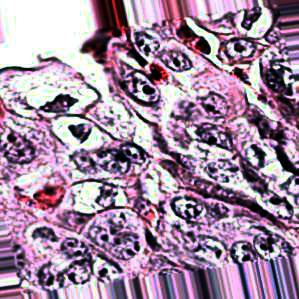

In [30]:
data_dir = 'D:/image_processing/Colon/test'

origin_img = os.path.join(data_dir, 'original_test/adenocarcinoma/TUM-TCGA-AAHIDTWA.jpg')
augmented_img = os.path.join(data_dir, 'augmented_test/test_aug/adenocarcinoma/aug_1_9687.jpg')
augmented_enhanced_img = os.path.join(data_dir, 'augmented_test/test_aug_enh/adenocarcinoma/adenocarcinoma_original_aug_0_9385.jpg_f79f8edc-3853-4e3c-b48c-2cb0f1ee7417.jpg')
augmented_enhanced_filtered_img = os.path.join(data_dir, 'augmented_test/test_filter/adenocarcinoma/adenocarcinoma_original_adenocarcinoma_original_aug_2_5541.jpg_0cf5246c-1ce5-45ca-851b-b98b9311a570.jpg_b1295ab0-4859-4383-945d-4f3c279ca642.jpg')
augmented_filtered_img = os.path.join(data_dir, 'augmented_test/test_aug_filter/adenocarcinoma/adenocarcinoma_original_aug_1_9687.jpg_f919a760-f447-4a4b-a4ac-f7c85e8a68d6.jpg')


origin = Im(origin_img) 
augmented = Im(augmented_img)
augmented_enhanced = Im(augmented_enhanced_img)
augmented_enhanced_filtered = Im(augmented_enhanced_filtered_img)
augmented_filtered = Im(augmented_filtered_img)

print('Original Image with Accuracy 98.76%')
display(origin)

print('Augmented Image with Accuracy 87.18%')
display(augmented)

print('Augmented Enhanced Image with Accuracy 84.00%')
display(augmented_enhanced)

print('Augmented Enhanced Filtered Image with Accuracy 71.19%')
display(augmented_enhanced_filtered)

print('Augmented Filtered Image with Accuracy 71.65%')
display(augmented_filtered)

# 6. Conclusion

### 6.1 The model performed relatively well (accuracy range 87% : 84%) on the enhanced and distorted images because the image had its colour present which is one of the main features in training the model.

### 6.2 After applying the Histogram Equalisation filter on the enhanced and distorted images it took out this feature by normalising the colours in the images which made it difficult for the model to evaluate. 

### 6.3 We may furthur train our model on the enhanced data to see if the model would generalize well on a distorted image.